# Model Creation 1 - testing different methods
Here we will test first ideas and choose the best-performing ones for further improvements.

A good TAD finding method should be stable (to different data resolution) and the dound TADs should be well defined. 

Here we will visually test the method performance, as a human is very adept at finding visual patterns. Other metrics of TAD quality will be used later when we will test the methods on a larger scale.

## Loading libraries

In [31]:
import straw
import math
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm, Normalize
import seaborn as sns
import sklearn 
import networkx as nx
import igraph as ig
from itertools import count
from scipy import ndimage
from scipy.interpolate import interp1d, make_interp_spline, UnivariateSpline
from scipy.signal import find_peaks
from sklearn.decomposition import NMF
from scipy.sparse import csgraph
# from libnmf.gnmf import GNMF
from scipy.spatial import distance_matrix
import networkx as nx
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

## Loading data
When loading data we specify:
- (data_type: 'observed' (previous default / "main" data) or 'oe' (observed/expected)),
- the normalizaton type (NONE, VC, VC_SQRT, KR, SCALE, etc.),
- path to the file,
- chromosome 1,
- chromosome 2 (chromosome 1 should be the same as chromosome 2, sense we are searching for TADs),
- type of fragment innteractions (BP - basic pair),
- resolution (resolution: typically 2500000, 1000000, 500000, 100000, 50000, 25000, 10000, 5000, etc.)

[hic-straw documentation](https://pypi.org/project/hic-straw/)

In [47]:
def get_df(normalisation, file_path, chromosome_1, chromosome_2, length_unit, resolution):
    # Data from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE63525
    # GSE63525_GM12878_diploid_maternal.hic
    df = straw.straw(normalisation, file_path, chromosome_1, chromosome_2, length_unit, resolution) 
    # example values: "KR", "../Data/GSE63525_GM12878_diploid_maternal.hic", "11", "11", "BP", 500000

    # Transforming the list to a data frame with three columns.
    # Origininally the raed data is a list of three lists, 
    # each with the same length (list of x, y and counts).
    df = pd.DataFrame(df).transpose()
    df.columns = ['x', 'y', 'count']

    return df
    
    
def general_information_about_df(df):
    print(f'Number of rows: {len(df)}')
    print(f"Number of unique x and y values: {df['x'].nunique()}, {df['y'].nunique()}")
    print(f"Mean interactions per fragment {df['count'].mean()}")
    print(f"Median of interactions per fragment {df['count'].median()}")

In [190]:
df = get_df("KR", "../Data/GSE63525_GM12878_diploid_maternal.hic", "11", "11", "BP", 500000)
matrix = np.nan_to_num(df.pivot(index='x', columns='y', values='count').to_numpy(),
                       copy=True, nan=0.0, posinf=None, neginf=None)
matrix = matrix + matrix.T - np.diag(matrix.diagonal())
general_information_about_df(df)

HiC version:  7
Number of rows: 35209
Number of unique x and y values: 265, 265
Mean interactions per fragment 216.44275425214323
Median of interactions per fragment 44.742856910143935


In [191]:
df2 = get_df("KR", "../Data/GSE63525_GM12878_diploid_maternal.hic", "11", "11", "BP", 100000)
matrix2 = np.nan_to_num(df2.pivot(index='x', columns='y', values='count').to_numpy(),
                       copy=True, nan=0.0, posinf=None, neginf=None)
matrix2 = matrix2 + matrix2.T - np.diag(matrix2.diagonal())
general_information_about_df(df2)

HiC version:  7
Number of rows: 604977
Number of unique x and y values: 1316, 1316
Mean interactions per fragment 12.423871180692371
Median of interactions per fragment 3.0443221075147715


## Contact matrix

In [192]:
def draw_contact_matrix(matrix):
    sns.set_theme(rc={'figure.figsize':(4, 4)})
    sns.heatmap(matrix, cbar=False, vmin=0, square=True, norm=LogNorm(), cmap='Reds')
    plt.gca().invert_yaxis()
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(True)
    plt.show()
    
def draw_contact_matrix_with_boundries(matrix, tad_boundaries):
    sns.set_theme(rc={'figure.figsize':(4, 4)})
    sns.heatmap(matrix, cbar=False, vmin=0, square=True, norm=LogNorm(), cmap='Reds')
    for boundary in tad_boundaries:
        plt.axvline(x=boundary, color='blue', linestyle='--')
        plt.axhline(y=boundary, color='blue', linestyle='--')
    plt.gca().invert_yaxis()
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.show()

## Matrix smoothing
The default matrix is 
- unsmoothed.

Sparse matrix can impact negatively the results, so a good smoothing method is wanted. We will take a closer look the following smoothing methods:
- Median Filter,
- Gaussian filter,
- Mean Filter,
- Graph regularized non-negative matrix .

Below examples for get_df("KR", "../Data/GSE63525_GM12878_diploid_maternal.hic", "11", "11", "BP", 100000).

### Unsmoothed matrix

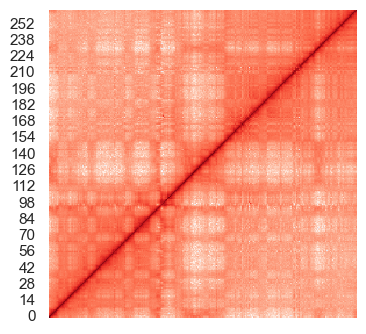

In [193]:
draw_contact_matrix(matrix)

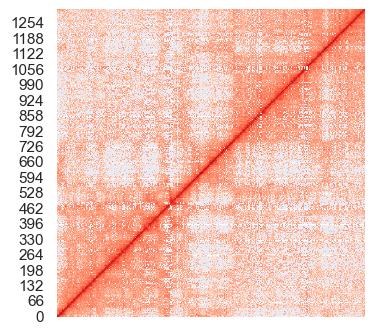

In [195]:
draw_contact_matrix(matrix2)

It is sparse indeed - for more datailed resolultion that is.

### Median filter

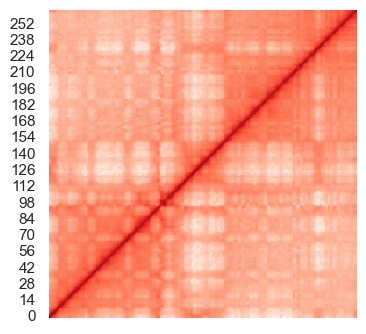

In [196]:
def median_filtering(matrix, size=3):
    """
    Apply median filtering to a sparse matrix.

    Parameters:
        matrix (numpy.ndarray): The input matrix.
        size (int): The size of the median filter kernel.

    Returns:
        numpy.ndarray: The smoothed matrix.
    """
    smoothed_matrix = ndimage.median_filter(matrix, size=size)
    return smoothed_matrix

matrix_tmp = median_filtering(matrix, size=3)
draw_contact_matrix(matrix_tmp)

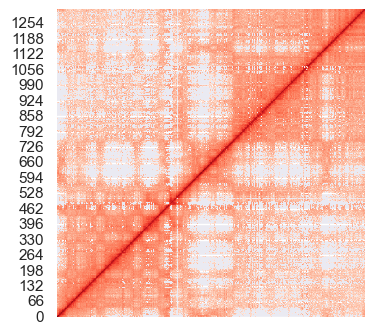

In [197]:
matrix_tmp = median_filtering(matrix2, size=3)
draw_contact_matrix(matrix_tmp)

It does seem to make the TADs more dense, however it is still sparse. But visually an improvement can be seen.

### Gaussian filter

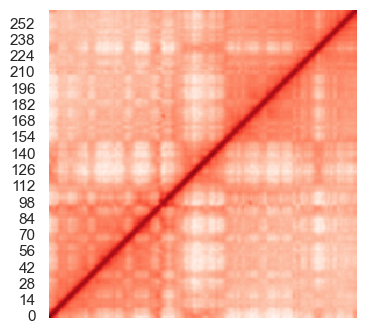

In [198]:
def gaussian_smoothing(matrix, sigma=1):
    """
    Apply Gaussian smoothing to a sparse matrix.

    Parameters:
        matrix (numpy.ndarray): The input matrix.
        sigma (float): Standard deviation of the Gaussian filter.

    Returns:
        numpy.ndarray: The smoothed matrix.
    """
    smoothed_matrix = ndimage.gaussian_filter(matrix, sigma=sigma)
    return smoothed_matrix

matrix_tmp = gaussian_smoothing(matrix, sigma=1)
draw_contact_matrix(matrix_tmp)

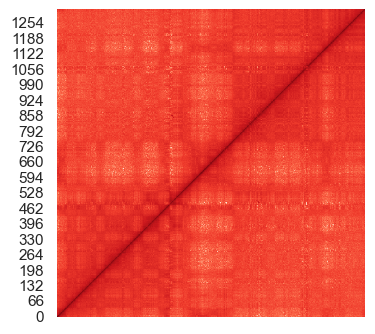

In [199]:
matrix_tmp = gaussian_smoothing(matrix2, sigma=1)
draw_contact_matrix(matrix_tmp)

With a better resolution this filter makes the values more uniform (and possibly harder to distinguish).

### Mean Filter

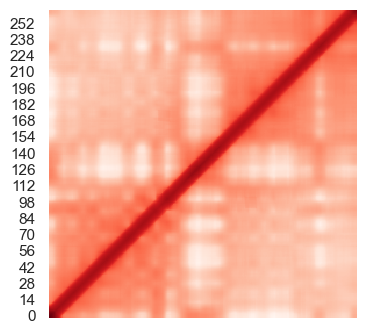

In [201]:
def mean_smoothing(matrix, size=1):
    """
    Apply Mean smoothing to a sparse matrix.

    Parameters:
        matrix (numpy.ndarray): The input matrix.
        sigma (float): Standard deviation of the Gaussian filter.

    Returns:
        numpy.ndarray: The smoothed matrix.
    """
    smoothed_matrix = ndimage.uniform_filter(matrix, size)
    return smoothed_matrix

matrix_tmp = mean_smoothing(matrix, 10)
draw_contact_matrix(matrix_tmp)

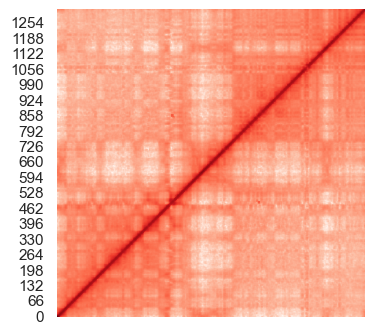

In [202]:
matrix_tmp = mean_smoothing(matrix2, 10)
draw_contact_matrix(matrix_tmp)

This filter does a good of removing sparsity while perserving the structure.

### Graph regularized non-negative matrix factorization

modyfied code from https://dangeles.github.io/jupyter/NMF_tutorial.html

This implementation leverages neighborhood information to enhance the factorization, which can be particularly useful in scenarios where local structure and relationships in the data are important.

error is 0.98
error is 0.96
error is 0.95
error is 0.94
error is 0.94
error is 0.94
error is 0.94
error is 0.94
error is 0.94
error is 0.94


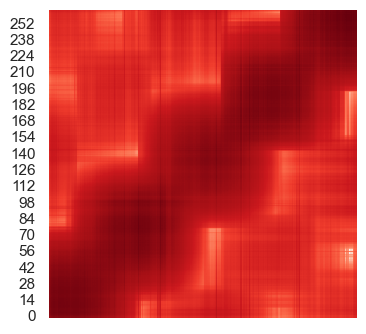

In [207]:
def update_H(W, H, X, r, lambd, C, DIAG):
    # initialize a new H
    newH = np.empty(H.shape)
    # calculate W.T * X (matrix multiply)
    N = np.dot(W.T, X) + lambd * np.dot(H, C)
    # calculate W.T * W * H (matrix multiply)
    D = np.dot(np.dot(W.T, W), H) + lambd * np.dot(H, DIAG)
    D = np.where(D==0, 0.01, D)
    # calculate H*N/D by element-wise multiplication
    newH = np.multiply(H, np.multiply(N, 1/D))
    return newH

def update_W(W, H, X, r, lambd, C, DIAG):
    # initialize a new W
    newW = np.empty(W.shape)
    # calculate X * H.T (matrix multiply)
    N = np.dot(X, H.T) + lambd * np.dot(C, W)
    # calculate W * H * H.T (matrix multiply)
    D = np.dot(np.dot(W, H), H.T) + lambd * np.dot(DIAG, W)
    D = np.where(D==0, 0.01, D)
    # calculate H*N/D by element-wise multiplication
    newW = np.multiply(W, np.multiply(N, 1/D))
    return newW

def run_nmf(k, X, iters=100, verbose=True, r=0, lambd=0):
    # normalize X
    X = X/X.std(axis=0)
    # if X has any negative entries, stop:
    if (X < 0).any():
        raise ValueError('X must be non-negative.')
    n, dims = X.shape
    # initialize W, the measurement by cluster matrix
    W = np.random.uniform(0, 1, (n, k))
    # initialize H, the cluster by genes matrix
    H = np.random.uniform(0, 1, (k, dims))
    # initialize a vector to store errors
    error = np.empty(iters)
    # iteratively update W and H
    
    # Neighbourhood matrix of distance r
    n = len(X)
    C = np.zeros([n, n])
    for i in range(-r, r + 1):
            C += np.eye(n, k=i, dtype=int)
    DIAG = np.diag(np.sum(C, axis=0))
    
    for i in np.arange(iters):
        H = update_H(W, H, X, r, lambd, C, DIAG)
        W = update_W(W, H, X, r, lambd, C, DIAG)
        e = np.sqrt(np.sum((X - W.dot(H))**2))
        e_rel = e/np.sqrt(np.sum(X**2))
        error[i] = e_rel
        if not verbose:
            continue
        if i % 10 == 0:
            print('error is {0:.2f}'.format(e_rel))
    return W, H, error


k = 5
W, H, error = run_nmf(k, matrix, r=30, lambd=0.7)

draw_contact_matrix(np.matmul(W, H))

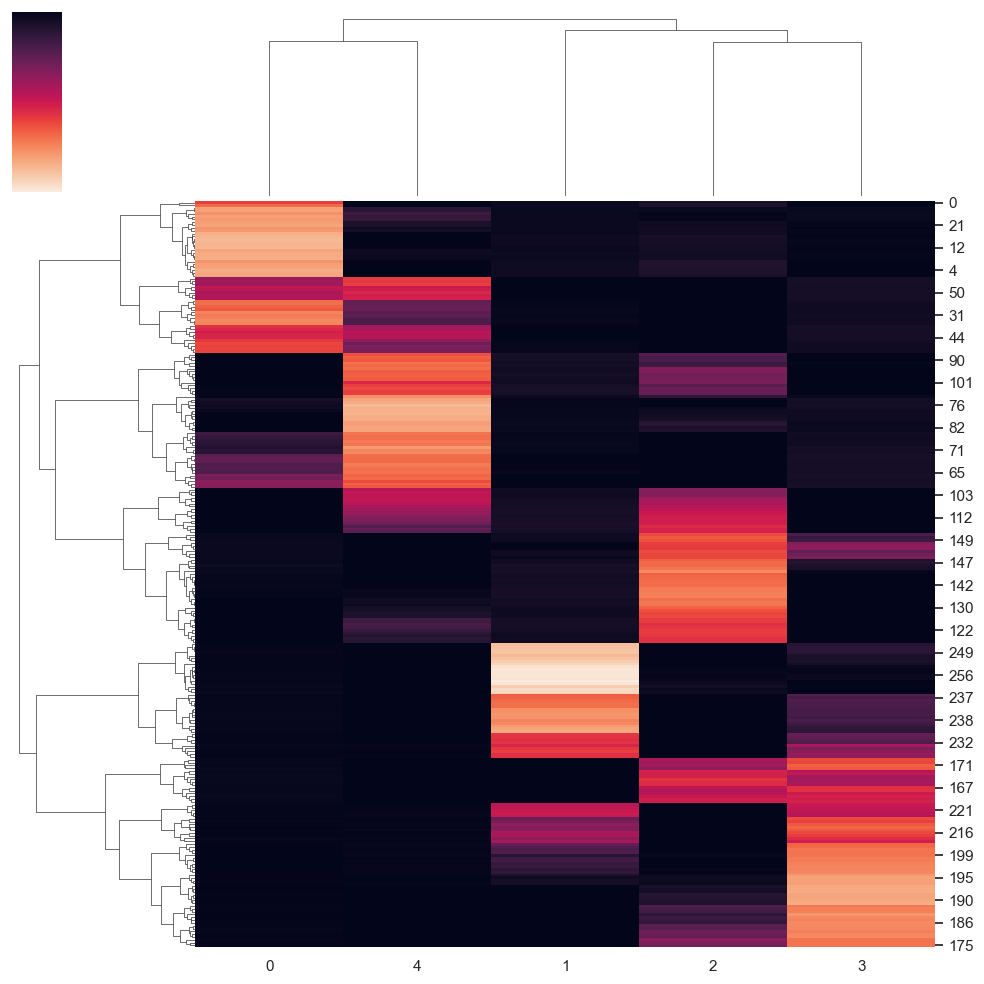

In [208]:
sns.set_theme(rc={'figure.figsize':(2, 2)})
sns.clustermap(W)
plt.gca().invert_yaxis()
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

This smoothing method could be useful, but there is a need to further optimize to parameters selection (which are different for different data) in order to enchance the wanted elements. When teaking these numbers by hand for a long time I couldn't find a set of parameters that would preserve the smallest TAD in the middle (that is very characteristic, as later sections will show).

For a matrix with resolution 100.000 (the shown in 500.000, so 17 times smaller) this function doesn't work.

## Matrix validation and correction
###  Check if matrix is symmetric

In [55]:
def is_symmetric(matrix):
    """
    Check if a matrix is symmetric.

    Parameters:
        matrix (list of lists): The input matrix.

    Returns:
        bool: True if the matrix is symmetric, False otherwise.
    """
    n = len(matrix)
    if n != len(matrix[0]):
        return False  # Matrix is not square, so it can't be symmetric

    for i in range(n):
        for j in range(i + 1, n):
            if matrix[i][j] != matrix[j][i]:
                return False  # If corresponding elements are not equal, matrix is not symmetric

    return True

###  Make matrix symetric

In [56]:
def make_symmetric(matrix):
    """
    Make a matrix symmetric by copying the lower triangle to the upper triangle.

    Parameters:
        matrix (list of lists): The input matrix.

    Returns:
        list of lists: The corrected symmetric matrix.
    """
    n = len(matrix)
    if n != len(matrix[0]):
        raise ValueError("Input matrix is not square")

    for i in range(n):
        for j in range(i + 1, n):
            matrix[j][i] = matrix[i][j]

    return matrix

### Finding based on insulation score of submatrices

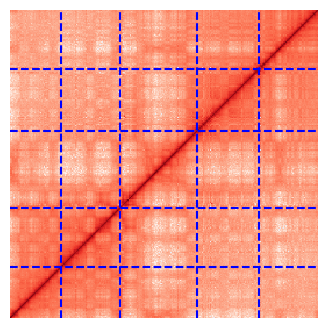

In [84]:
def calculate_insulation_score(contact_matrix, window_size):
    num_bins = contact_matrix.shape[0]
    insulation_scores = np.zeros(num_bins)
    
    for i in range(num_bins):
        start = max(0, i - window_size // 2)
        end = min(num_bins, i + window_size // 2 + 1)
        local_matrix = contact_matrix[start:end, start:end]
        insulation_scores[i] = np.mean(local_matrix)
    
    return insulation_scores

def find_tad_boundaries(insulation_scores, window_size):
    # Find local minima in the insulation score
    peaks, _ = find_peaks(-insulation_scores, distance=window_size)
    return peaks

def plot_contact_matrix_with_tads(contact_matrix, tad_boundaries):
    plt.figure(figsize=(8, 8))
    plt.imshow(np.log1p(contact_matrix), cmap='Reds', origin='lower')
    
    for boundary in tad_boundaries:
        plt.axvline(x=boundary, color='blue', linestyle='--')
        plt.axhline(y=boundary, color='blue', linestyle='--')
    
    plt.colorbar()
    plt.title('Contact Matrix with TAD Boundaries')
    plt.show()

# Parameters
window_size = 50

# Calculate insulation score
insulation_scores = calculate_insulation_score(matrix, window_size)

# Find TAD boundaries
tad_boundaries = find_tad_boundaries(insulation_scores, window_size)

# Plot the contact matrix with TAD boundaries
draw_contact_matrix_with_boundries(matrix, tad_boundaries)

Found TADs are very similar in size. In reality (and in example) TADs can have more varied sizes. This method needs improvements.

### Finding TADs based on directionality index

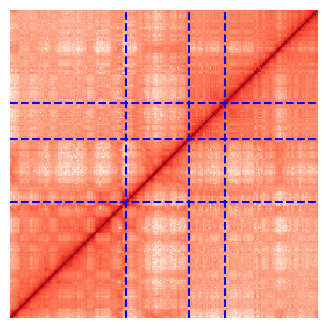

In [92]:
def calculate_directionality_index(contact_matrix, window_size):
    num_bins = contact_matrix.shape[0]
    di_scores = np.zeros(num_bins)
    
    for i in range(window_size, num_bins - window_size):
        upstream = np.sum(contact_matrix[i, i - window_size:i])
        downstream = np.sum(contact_matrix[i, i + 1:i + window_size + 1])
        total = upstream + downstream
        if total > 0:
            di_scores[i] = (downstream - upstream) / total
    
    return di_scores

def smooth_signal(signal, window_size):
    return ndimage.uniform_filter1d(signal, size=window_size)

def find_tad_boundaries(di_scores, smoothing_window_size, peak_distance):
    smoothed_di = smooth_signal(di_scores, smoothing_window_size)
    peaks, _ = find_peaks(np.abs(smoothed_di), distance=peak_distance)
    return peaks

def plot_contact_matrix_with_tads(contact_matrix, tad_boundaries):
    plt.figure(figsize=(8, 8))
    plt.imshow(np.log1p(contact_matrix), cmap='Reds', origin='lower')
    
    for boundary in tad_boundaries:
        plt.axvline(x=boundary, color='blue', linestyle='--')
        plt.axhline(y=boundary, color='blue', linestyle='--')
    
    plt.colorbar()
    plt.title('Contact Matrix with TAD Boundaries')
    plt.show()

# Parameters
window_size = 75
smoothing_window_size = 3
peak_distance = 30

# Calculate directionality index
di_scores = calculate_directionality_index(matrix, window_size)

# Find TAD boundaries
tad_boundaries = find_tad_boundaries(di_scores, smoothing_window_size, peak_distance)

# Plot the contact matrix with TAD boundaries
draw_contact_matrix_with_boundries(matrix, tad_boundaries)

This method seems to yeld satisfactory results and is very fast. However it is very sensitive to passed parameters. Optimal parameteres change based on the used data. In order to utilise this method well we would need to first find a way to search for good parameters. A naive approach would be to test different parameters and pick the set with the best metrics. That however requires a lot of computational power.

### Finding TADs with a graph laplacian from a graph regularized NMF

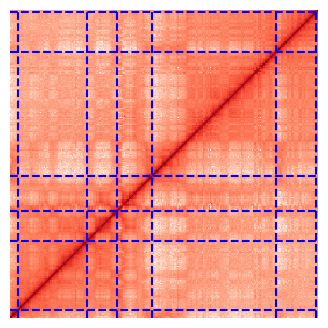

In [113]:
def normalize_contact_matrix(contact_matrix):
    contact_matrix = contact_matrix - np.min(contact_matrix)
    contact_matrix = contact_matrix / np.max(contact_matrix)
    return contact_matrix

def construct_graph_laplacian(contact_matrix, neighborhood_size):
    num_bins = contact_matrix.shape[0]
    W = np.zeros((num_bins, num_bins))

    for i in range(num_bins):
        for j in range(max(0, i - neighborhood_size), min(num_bins, i + neighborhood_size + 1)):
            if i != j:
                W[i, j] = 1
                W[j, i] = 1

    D = np.diag(np.sum(W, axis=1))
    L = D - W
    return L

def graph_regularized_nmf(contact_matrix, L, n_components, alpha, max_iter=200):
    model = NMF(n_components=n_components, init='random', random_state=0, max_iter=max_iter)
    H = model.fit_transform(contact_matrix)
    W = model.components_

    for iteration in range(max_iter):
        H = H * np.dot(contact_matrix, W.T) / (np.dot(H, np.dot(W, W.T)) + alpha * np.dot(L, H))
        W = W * np.dot(H.T, contact_matrix) / (np.dot(H.T, np.dot(H, W)) + alpha * np.dot(W, L))

    return H, W

def identify_tads(H, n_tads):
    tad_boundaries = np.argsort(-np.diff(H.mean(axis=1)))[:n_tads-1] + 1
    return np.sort(tad_boundaries)

def plot_contact_matrix_with_tads(contact_matrix, tad_boundaries):
    plt.figure(figsize=(8, 8))
    plt.imshow(np.log1p(contact_matrix), cmap='Reds', origin='lower')
    
    for boundary in tad_boundaries:
        plt.axvline(x=boundary, color='blue', linestyle='--')
        plt.axhline(y=boundary, color='blue', linestyle='--')
    
    plt.colorbar()
    plt.title('Contact Matrix with TAD Boundaries')
    plt.show()

# Normalize the contact matrix
contact_matrix = normalize_contact_matrix(matrix)

# User-specified parameters
n_tads = 7
neighborhood_size = 5  # Size of the neighborhood for regularization
alpha = 0.2  # Strength of regularization

# Construct the graph Laplacian
L = construct_graph_laplacian(contact_matrix, neighborhood_size)

# Apply Graph Regularized NMF
H, W = graph_regularized_nmf(contact_matrix, L, n_components=n_tads, alpha=alpha, max_iter=200)

# Identify TADs
tad_boundaries = identify_tads(H, n_tads)

# Plot the contact matrix with TAD boundaries
draw_contact_matrix_with_boundries(contact_matrix, tad_boundaries)

<Axes: >

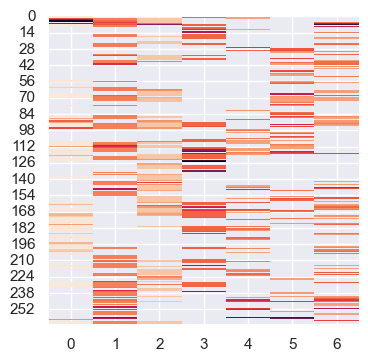

In [102]:
sns.heatmap(H, cbar=False, vmin=0, square=False, norm=LogNorm())

## Finding TADs using community detection algorithm
Using louvain_communities from networkx library

In [79]:
G=nx.from_numpy_array(matrix)

list(list(G.edges(data=True))[0][-1].keys())

['weight']

In [89]:
comp = nx.community.girvan_newman(G)
for communities in itertools.islice(comp, 2):
    print(tuple(sorted(c) for c in communities))

In [4]:
nx.community.louvain_communities(G, seed=42)

[{0, 1, 2, 3, 4, 5, 6, 7},
 {8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20},
 {21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32},
 {33, 34, 35, 36},
 {37, 38, 39, 40, 41, 42, 43},
 {44, 45, 46, 47},
 {48, 49, 50, 51, 52, 53, 54, 55, 56, 57},
 {58, 59, 60, 61, 62, 63, 64, 65},
 {66, 67, 68, 69, 70, 71, 72, 73, 74, 75},
 {76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86},
 {87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100},
 {101, 102, 103, 104, 105, 106, 107, 108, 109},
 {110, 111, 112, 113, 114},
 {115, 116, 117, 118, 119, 120, 121},
 {122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132}]

HiC version:  7


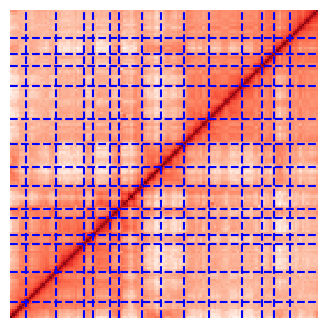

In [98]:
df2 = get_df("KR", "../Data/GSE63525_GM12878_diploid_maternal.hic", "11", "11", "BP", 1000000)
matrix2 = np.nan_to_num(df2.pivot(index='x', columns='y', values='count').to_numpy(),
                       copy=True, nan=0.0, posinf=None, neginf=None)
matrix2 = matrix2 + matrix2.T - np.diag(matrix2.diagonal())

def largest_items_from_sets(sets):
    """
    Get the largest item from each set in a list of sets.

    Parameters:
        sets (list of sets): The input list of sets.

    Returns:
        list: A list of the largest items from each set.
    """
    largest_items = [max(s) for s in sets]
    return largest_items

# Below is pasted result from above
# tad_boundaries = largest_items_from_sets([{0, 1, 2, 3, 4, 5, 6, 7},
#  {8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20},
#  {21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32},
#  {33, 34, 35, 36},
#  {37, 38, 39, 40, 41, 42, 43},
#  {44, 45, 46, 47},
#  {48, 49, 50, 51, 52, 53, 54, 55, 56, 57},
#  {58, 59, 60, 61, 62, 63, 64, 65},
#  {66, 67, 68, 69, 70, 71, 72, 73, 74, 75},
#  {76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86},
#  {87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100},
#  {101, 102, 103, 104, 105, 106, 107, 108, 109},
#  {110, 111, 112, 113, 114},
#  {115, 116, 117, 118, 119, 120, 121},
#  {122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132}])

# Plot the contact matrix with TAD boundaries
draw_contact_matrix_with_boundries(matrix2, tad_boundaries[:-1])

Like the mothod above, this method seems to yeld satisfactory results and is very fast. However it is very sensitive to passed parameters. Optimal parameteres change based on the used data. In order to utilise this method well we would need to first find a way to search for good parameters. A naive approach would be to test different parameters and pick the set with the best metrics. That however requires a lot of computational power.

## Calculating sums/averages along diagonal
Sums of values inside a square matrix of given radious with a center on diagonal will be calculated.

The idea is that when we encounter TADs, which have square shape placed along the diagonal, we will have a larger sum. By checking different summing square (kernel) positions and trying different sizes we should be able to detect places with increases and decreases in sums.

###  Calculate sum with given radious

In [58]:
def diagonal_sums(matrix, r):
    """
    Compute the sums of elements inside square submatrices along the diagonal of a given matrix.

    Parameters:
        matrix (numpy.ndarray): The input matrix.
        r (int): The size of the square submatrix.

    Returns:
        list: A list of sums of elements inside each square submatrix along the diagonal.
    """
    n = matrix.shape[0]
    sums = []

    for i in range(0, n - r + 1):
        submatrix = matrix[i:i+r, i:i+r]
        submatrix_sum = np.sum(submatrix)
        sums.append(submatrix_sum)
    
    return sums

# in:
# print(diagonal_sums(
#     np.array([
#     [1, 2, 3, 4, 5],
#     [1, 2, 3, 4, 5],
#     [1, 2, 3, 4, 5],
#     [1, 2, 3, 4, 5],
#     [1, 2, 3, 4, 5]
# ]), 2))
# out:
# [6, 10, 14, 18]

###  Calculate average with given radious
Sense we are interested in a relative increases of counts in a given sumbatrix radious, the average seems to be a better metric. It allows the numbers to be comparable between different values of kernel sizes (sums will always be larger for larger kernels).

In [59]:
def diagonal_averages(matrix, r):
    """
    Compute the average of sums of elements inside square submatrices along the diagonal of a given matrix
    per element in the submatrix.

    Parameters:
        matrix (numpy.ndarray): The input matrix.
        r (int): The size of the square submatrix.

    Returns:
        list: A list of sums of elements inside each square submatrix along the diagonal.
    """
    n = matrix.shape[0]
    sums = []

    for i in range(0, n - r + 1):
        submatrix = matrix[i:i+r, i:i+r]
        submatrix_sum = np.sum(submatrix)/(r*r)
        sums.append(submatrix_sum)
    
    return sums

# in:
# print(diagonal_averages(
#     np.array([
#     [1, 2, 3, 4, 5],
#     [1, 2, 3, 4, 5],
#     [1, 2, 3, 4, 5],
#     [1, 2, 3, 4, 5],
#     [1, 2, 3, 4, 5]
# ]), 2))
# out:
# [1.5, 2.5, 3.5, 4.5]

### Visualize the results

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
def draw_scatterplots(list_of_lists):
    """
    Draw scatterplots for a list of lists with numbers.

    Parameters:
        list_of_lists (list of lists): The input list of lists with numbers.
    """
    # Define the maximum number of lists per scatterplot and the number of columns
    max_lists_per_plot = 5
    max_columns = 3

    # Calculate the number of rows and columns needed
    num_plots = len(list_of_lists)
    num_columns = min(max_columns, (num_plots + max_lists_per_plot - 1) // max_lists_per_plot)
    num_rows = (num_plots + max_lists_per_plot * num_columns - 1) // (max_lists_per_plot * num_columns)
    
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(5 * num_columns, 5 * num_rows))
    if num_rows == 1 and num_columns == 1:
        axes = np.array([[axes]])
    elif num_rows == 1:
        axes = np.array([axes])
    elif num_columns == 1:
        axes = axes[:, np.newaxis]

    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        start = i * max_lists_per_plot
        end = min((i + 1) * max_lists_per_plot, num_plots)
        if start >= num_plots:
            fig.delaxes(ax)
            continue
        for j in range(start, end):
            x = np.arange(len(list_of_lists[j]))
            y = list_of_lists[j]
            ax.scatter(x, y, label=f'r={j + 1}')

            ax.hlines(y=np.mean(y), xmin=0, xmax=max(x), linewidth=1, linestyles='--')
            
        ax.legend()
        ax.set_xlabel('Index')
        ax.set_ylabel('Value')
    
    plt.tight_layout()
    plt.show()

#### For sums

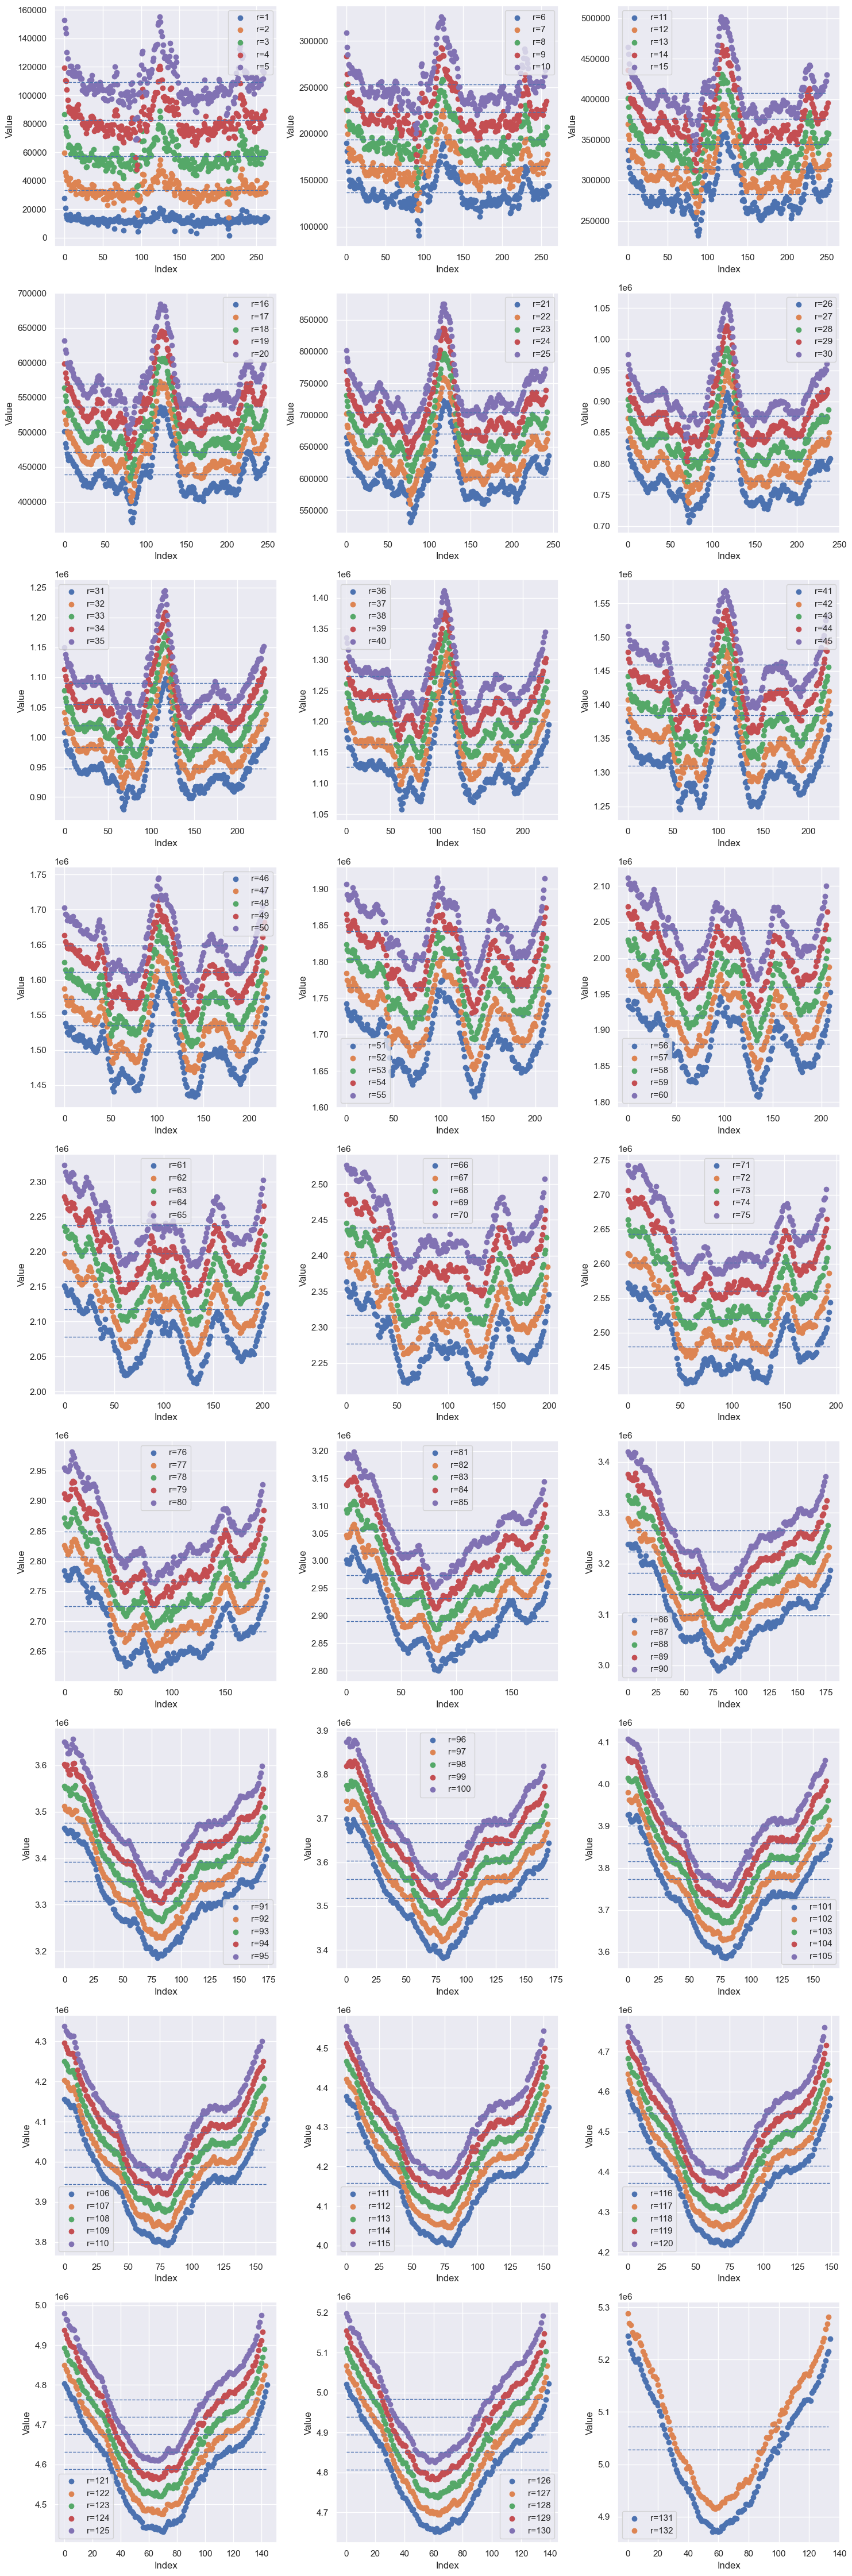

In [61]:
sums = []
max_r = math.floor(len(matrix)/2)
for i in range(1, max_r+1):
    sums.append(diagonal_sums(matrix, i))
    
draw_scatterplots(sums)

#### For averages

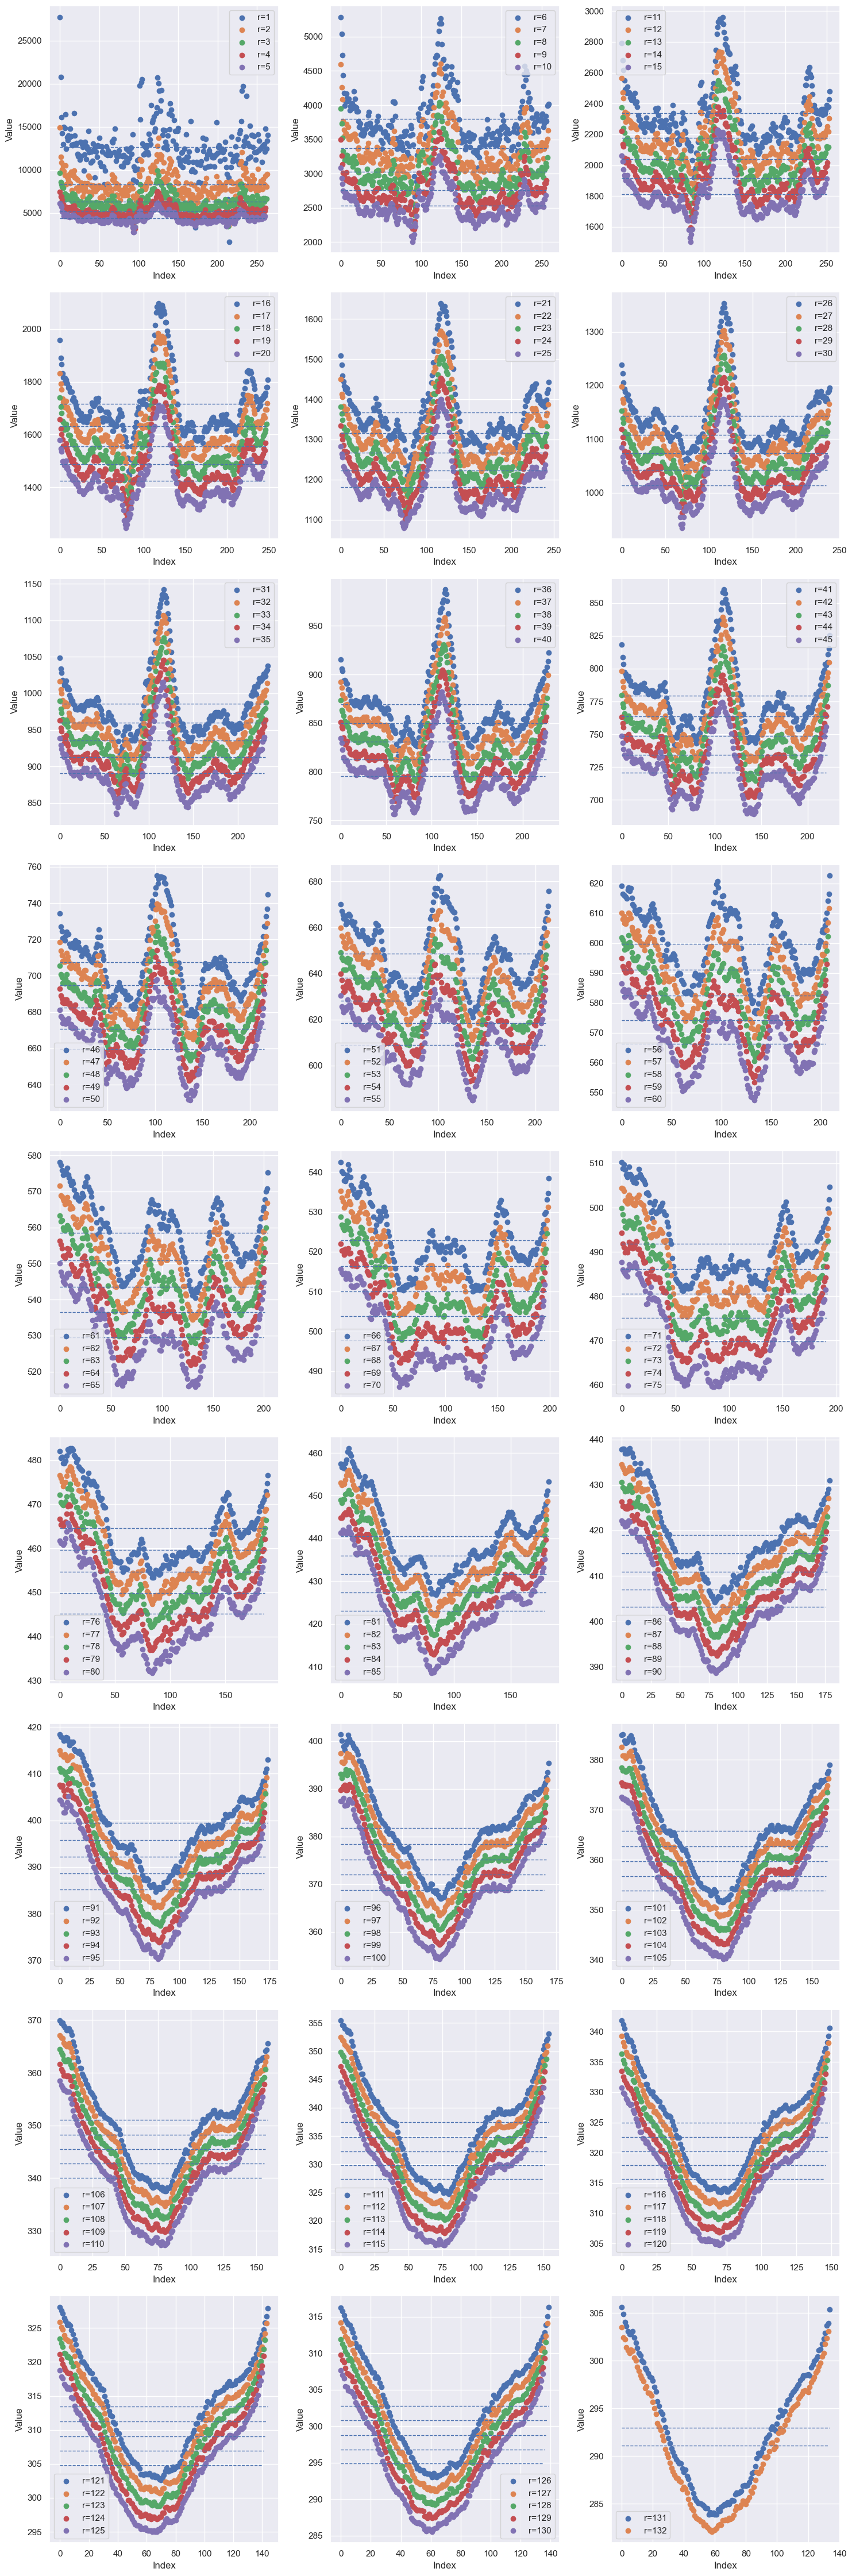

In [62]:
sums = []
max_r = math.floor(len(matrix)/2)
for i in range(1, max_r+1):
    sums.append(diagonal_averages(matrix, i))

draw_scatterplots(sums)

In [64]:
def process_lists(list_of_lists):
    """
    Process each list in the list of lists:
    1. Separate values greater than the mean of the list.
    2. Find continuous sequences where more than 10% of all values are present.
    3. Find the maximum value for such sequences.
    4. Place the indexes corresponding to max values in a list.
    5. Place these lists in a list and return the result.

    Parameters:
        list_of_lists (list of lists): The input list of lists.

    Returns:
        list: A list containing lists of indexes corresponding to maximum values for each list.
    """
    result = []
    
    for lst in list_of_lists:
        mean_value = np.mean(lst)
        continuous_sequences_max = []
        
        # Separate values greater than the mean (rest set to 0)
        for i in range(len(lst)):
            if lst[i] < mean_value:
                lst[i] = 0
                
        # Find continuous sequences (separator is 0) where more than 10% of all values are present
        continuous_sequences = [0] * len(lst)

        sequence_length = math.floor(len(lst)*0.1+1)
        for i in range(len(lst) - sequence_length + 1):
            if all(lst[i+j] != 0 for j in range(sequence_length)):
                continuous_sequences[i:i+sequence_length] = lst[i:i+sequence_length]
                
                
        # Fina max values in sequences (separated by 0) and  change non-max values to 0
        start = 0
        for i in range(len(continuous_sequences)):
            if continuous_sequences[i] == 0:
                if start != i:
                    max_value = max(continuous_sequences[start:i])
                    continuous_sequences_max.extend([0 if val != max_value else val for val in continuous_sequences[start:i]])
                continuous_sequences_max.append(0)  # Append the 0 separator
                start = i + 1
            elif i == len(continuous_sequences) - 1:
                max_value = max(continuous_sequences[start:i + 1])
                continuous_sequences_max.extend([0 if val != max_value else val for val in continuous_sequences[start:i + 1]])
                    
        # Find all indexes of non-0 values
        result.append([i for i, val in enumerate(continuous_sequences_max) if val != 0])
        
    return result

result = process_lists(sums)
# print("Result:", result)

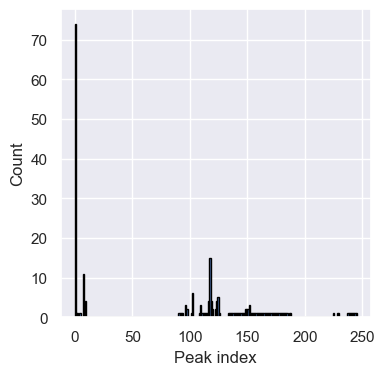

In [65]:
def create_histogram(list_of_lists):
    """
    Create a histogram with bins spaced 1 for the given list of lists.

    Parameters:
        list_of_lists (list of lists): The input list of lists with numbers.
    """
    # Flatten the list of lists
    flattened_list = [value for sub_list in list_of_lists for value in sub_list]
    
    # Create the histogram
    plt.hist(flattened_list, bins=range(int(min(flattened_list)), int(max(flattened_list)) + 2), edgecolor='black')
    
    # Set labels and title
    plt.xlabel('Peak index')
    plt.ylabel('Count')
    
    # Show the plot
    plt.grid(True)
    plt.show()
    
create_histogram(result)

In [66]:
sorted_peaks = sorted(Counter([value for sub_list in result for value in sub_list]).items(), key=lambda x: x[1], reverse=True)

In [76]:
tad_boundaries = []
for peak in sorted_peaks[:10]:
    tad_boundaries.append(peak[0])

In [77]:
tad_boundaries

[0, 117, 7, 102, 124, 123, 118, 116, 9, 109]

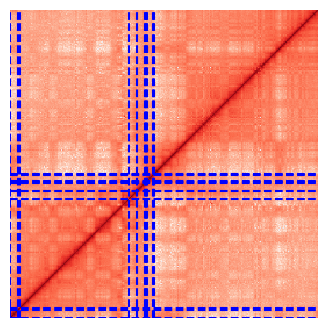

In [78]:
draw_contact_matrix_with_boundries(matrix, tad_boundaries)

#### With different sumber of first  peaks

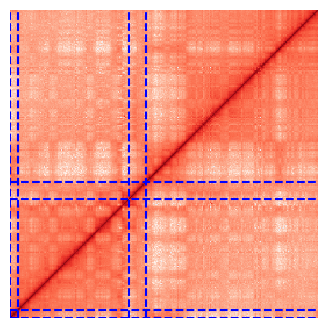

In [224]:
n_vals = 4

draw_contact_matrix_with_boundries(matrix,
[peak[0] for peak in 
 sorted(Counter([value for sub_list
                 in process_lists([diagonal_averages(matrix, i) for i in 
                                   range(1, math.floor(len(matrix)/2)+1)]) for value in
                 sub_list]).items(), key=lambda x: x[1], reverse=True)[:n_vals]])

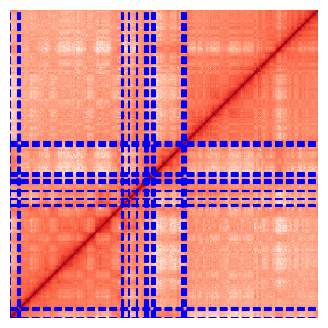

In [220]:
n_vals = 20

draw_contact_matrix_with_boundries(matrix,
[peak[0] for peak in 
 sorted(Counter([value for sub_list
                 in process_lists([diagonal_averages(matrix, i) for i in 
                                   range(1, math.floor(len(matrix)/2)+1)]) for value in
                 sub_list]).items(), key=lambda x: x[1], reverse=True)[:n_vals]])

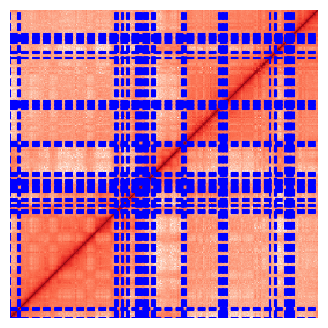

In [221]:
n_vals = 50

draw_contact_matrix_with_boundries(matrix,
[peak[0] for peak in 
 sorted(Counter([value for sub_list
                 in process_lists([diagonal_averages(matrix, i) for i in 
                                   range(1, math.floor(len(matrix)/2)+1)]) for value in
                 sub_list]).items(), key=lambda x: x[1], reverse=True)[:n_vals]])

#### For different matrix resolution

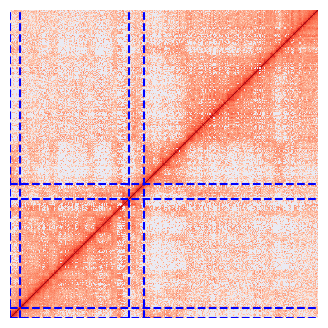

In [226]:
n_vals = 4

draw_contact_matrix_with_boundries(matrix2,
[peak[0] for peak in 
 sorted(Counter([value for sub_list
                 in process_lists([diagonal_averages(matrix2, i) for i in 
                                   range(1, math.floor(len(matrix2)/2)+1)]) for value in
                 sub_list]).items(), key=lambda x: x[1], reverse=True)[:n_vals]])

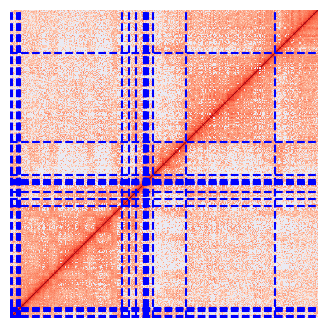

In [227]:
n_vals = 20

draw_contact_matrix_with_boundries(matrix2,
[peak[0] for peak in 
 sorted(Counter([value for sub_list
                 in process_lists([diagonal_averages(matrix2, i) for i in 
                                   range(1, math.floor(len(matrix2)/2)+1)]) for value in
                 sub_list]).items(), key=lambda x: x[1], reverse=True)[:n_vals]])

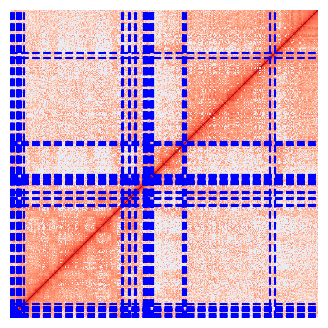

In [225]:
n_vals = 50

draw_contact_matrix_with_boundries(matrix2,
[peak[0] for peak in 
 sorted(Counter([value for sub_list
                 in process_lists([diagonal_averages(matrix2, i) for i in 
                                   range(1, math.floor(len(matrix2)/2)+1)]) for value in
                 sub_list]).items(), key=lambda x: x[1], reverse=True)[:n_vals]])

### Test on a smoothed matrix

Matrix is not symmetric. Fixed.


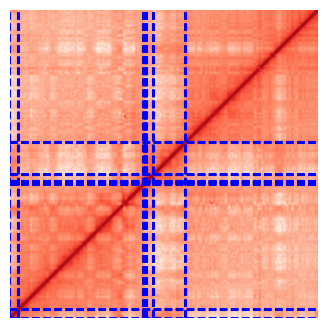

In [238]:
matrix_tmp = mean_smoothing(matrix2, 10)

n_vals = 20

if not is_symmetric(matrix_tmp):
    print('Matrix is not symmetric. Fixed.')
    make_symmetric(matrix_tmp)
else:
    print('Matrix is symmetric.')

draw_contact_matrix_with_boundries(matrix_tmp,
[peak[0] for peak in 
 sorted(Counter([value for sub_list
                 in process_lists([diagonal_averages(matrix_tmp, i) for i in 
                                   range(1, math.floor(len(matrix_tmp)/2)+1)]) for value in
                 sub_list]).items(), key=lambda x: x[1], reverse=True)[:n_vals]])

This method correctly identifies TADs (based on human opinion) and they seem to be stable when changing the resolution.

The only problem is that close to some of the boundries there are multiple peaks detected. That however can be easily fixed, by merging the boundries found later with the already found ones (if the boundry distance is smaller than x).

### Getting 2 max peaks from >r distance from each other

In [167]:
def max_and_second_max(list_of_lists):
    """
    Get the max value and the second max value from each sublist.

    Parameters:
        list_of_lists (list of lists): The input list of lists.
        r (int): The sublist number.

    Returns:
        list of lists: A list of size 2 containing the max value and the second max value for each sublist.
    """
    result = []
    for r, sublist in enumerate(list_of_lists):
        max_val_index = sublist.index(max(sublist))
        second_max = None
        second_max_index = None
        for i in range(max_val_index + r + 1, len(sublist)):
            if sublist[i] != sublist[max_val_index]:
                second_max = sublist[i]
                second_max_index = i
                break
        if second_max is None:
            for i in range(max_val_index - r - 1, -1, -1):
                if sublist[i] != sublist[max_val_index]:
                    second_max = sublist[i]
                    second_max_index = i
                    break
        result.append([max_val_index, second_max_index])
    return result

two_maxes = max_and_second_max(sums)

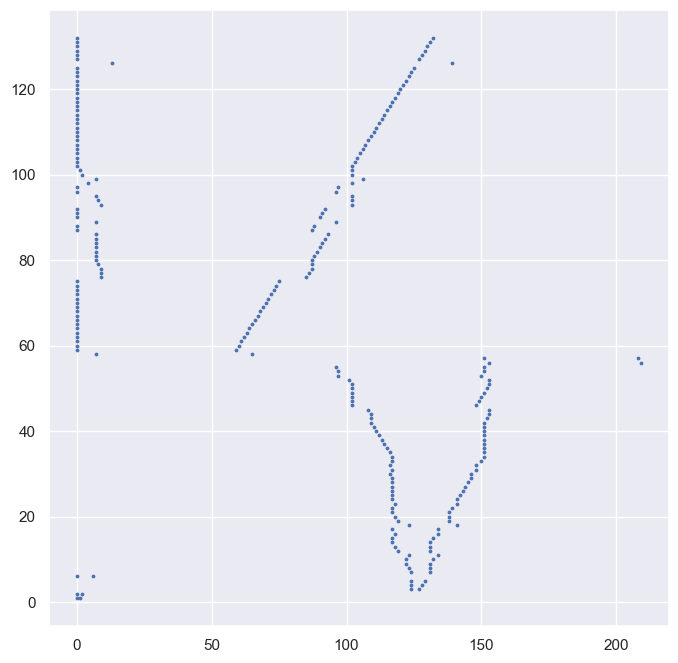

In [170]:
plt.figure(figsize=(8,  8))
plt.scatter([value for sub_sizes in two_maxes for value in sub_sizes],
            [i // 2 + 1 for i in range(len([value for sub_sizes in two_maxes for value in sub_sizes]))],
           s=3)
plt.show()

Two most characteristic TADs have been found, but there are more in the HiC matrix. It should be possible to find more peaks when finding more maxima, but the question is when to stop. The current method restricting finding maxima in a given range is flawed, because for smaller kernel sizes it can find peaks where there are none, and it's impossible to place good boundary from the start.

### Finding TADs with values of max-10% per kernel radious iteration

In [127]:
def get_max_and_less_than_10_percent(list_of_lists):
    """
    Get indexes of maximum value and values less than 10% smaller than the maximum for each sublist.

    Parameters:
        list_of_lists (list of lists): The input list of lists with numbers.

    Returns:
        list of lists: A new list of lists containing indexes of selected values.
    """
    new_list_of_lists = []
    list_of_sizes=[]

    for r, sublist in enumerate(list_of_lists):
        max_value = max(sublist)
        threshold = max_value * 0.95
        selected_indexes = [i for i, val in enumerate(sublist) if val >= threshold]
        new_list_of_lists.append(selected_indexes)
        list_of_sizes.append([r for i in range(len(selected_indexes))])

    return new_list_of_lists, list_of_sizes

peaks, sizes = get_max_and_less_than_10_percent(sums)

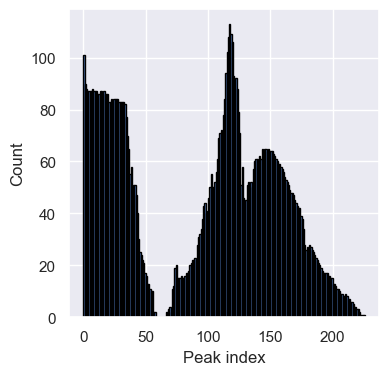

In [128]:
def create_histogram(list_of_lists):
    """
    Create a histogram with bins spaced 1 for the given list of lists.

    Parameters:
        list_of_lists (list of lists): The input list of lists with numbers.
    """
    # Flatten the list of lists
    flattened_list = [value for sub_list in list_of_lists for value in sub_list]
    
    # Create the histogram
    plt.hist(flattened_list, bins=range(int(min(flattened_list)), int(max(flattened_list)) + 2), edgecolor='black')
    
    # Set labels and title
    plt.xlabel('Peak index')
    plt.ylabel('Count')
    
    # Show the plot
    plt.grid(True)
    plt.show()
    
create_histogram(peaks)

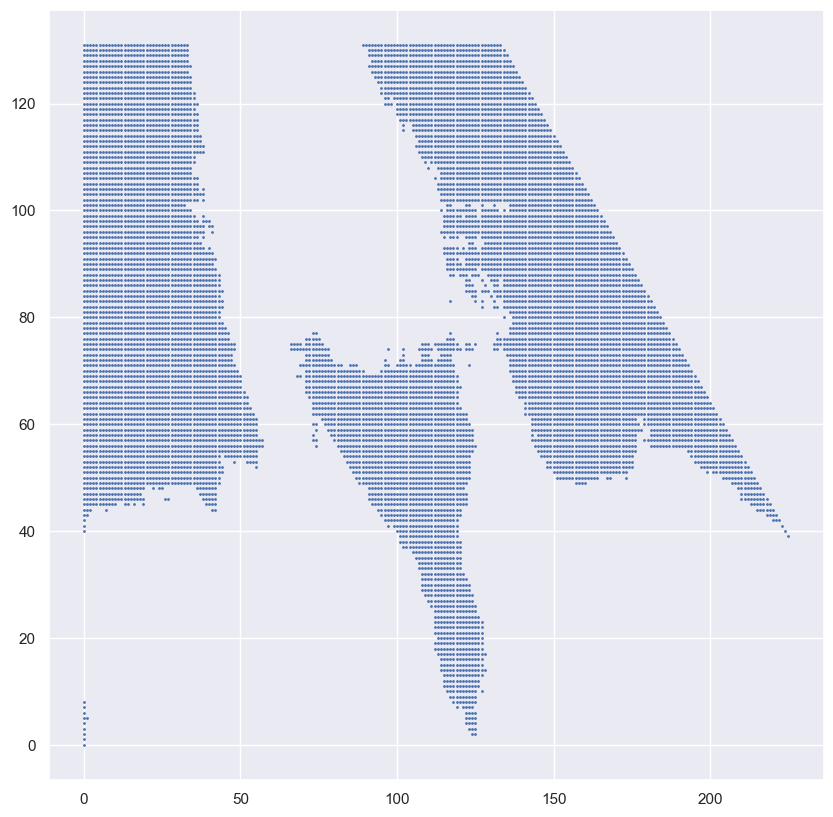

In [129]:
plt.figure(figsize=(10,  10))
plt.scatter([value for sub_peaks in peaks for value in sub_peaks],
            [value for sub_sizes in sizes for value in sub_sizes],
           s=1)
plt.show()

It does seem to find the most obvious peaks, but to further get a more detailed map of TAD distribution the created data is hard to work with.

### Finding TADs based on splitting an array of sums inside a kernel of varied size
The function splitArraySameSum splits an array arr into k contiguous subarrays such that the maximum sum among these subarrays is minimized.

Prefix Sum Calculation: It first calculates the prefix sum array, which helps in quickly computing the sum of any subarray. The prefix sum array prefix_sum is constructed such that prefix_sum[i] is the sum of elements from arr[0] to arr[i-1].

Dynamic Programming Table Initialization: It initializes a dynamic programming (DP) table dp where dp[i][j] represents the minimum possible maximum subarray sum when splitting the first i elements of arr into j subarrays. A partition table partition is also created to help reconstruct the subarrays.

Filling the DP Table: The function iterates through all possible subarray endpoints and updates the DP table:

For each element i and each possible number of subarrays j, it considers all possible positions m to split the subarray.
It computes the current subarray sum current_sum from arr[m] to arr[i-1] using the prefix sum array.
It updates dp[i][j] to be the minimum of its current value and the maximum of dp[m][j-1] (the optimal value for the previous subarray) and current_sum.
Reconstructing Subarrays: After filling the DP table, the function reconstructs the subarrays from the partition table. It starts from the end of the array and uses the partition table to trace back the positions where the splits were made.

Returning the Result: The function returns the reconstructed subarrays in the correct order.

The second part of the code runs this function for different values of r and prints out the lengths of the resulting subarrays after each split:

k is set to 4, meaning the array will be split into 4 subarrays.
r_min and r_max define the range for r, which seems to be used in the function diagonal_averages(matrix, i) to generate the input array.
For each r in the specified range, the diagonal_averages(matrix, i) function generates an array, which is then split into k subarrays using splitArraySameSum.
The code prints the cumulative lengths of the subarrays up to the k-1-th subarray for each r.

In [119]:
def splitArraySameSum(arr, k):
    n = len(arr)
    
    # Helper function to calculate the sum from arr[i] to arr[j]
    def get_sum(i, j):
        return prefix_sum[j + 1] - prefix_sum[i]

    # Step 1: Create a prefix sum array
    prefix_sum = [0] * (n + 1)
    for i in range(n):
        prefix_sum[i + 1] = prefix_sum[i] + arr[i]
    
    # Step 2: Create a dp table and a partition table
    dp = [[float('inf')] * (k + 1) for _ in range(n + 1)]
    partition = [[0] * (k + 1) for _ in range(n + 1)]
    dp[0][0] = 0
    
    # Step 3: Fill the dp table
    for i in range(1, n + 1):
        for j in range(1, k + 1):
            for m in range(i):
                current_sum = get_sum(m, i - 1)
                if max(dp[m][j-1], current_sum) < dp[i][j]:
                    dp[i][j] = max(dp[m][j-1], current_sum)
                    partition[i][j] = m
    
    # Step 4: Reconstruct the subarrays from the partition table
    subarrays = []
    current_index = n
    for i in range(k, 0, -1):
        prev_index = partition[current_index][i]
        subarrays.append(arr[prev_index:current_index])
        current_index = prev_index
    
    return subarrays[::-1]

k = 5
r_min = 10
r_max = 50
for i in range(r_min, r_max):
    print(f'r: {i}: ', end='')
    arrays = splitArraySameSum(diagonal_averages(matrix, i), k)
    prev_len = 0
    for j in range(k-1):
        prev_len += len(arrays[j])
        print(f'{prev_len} ', end='')
    print()

r: 10: 50 104 150 205 
r: 11: 50 104 150 204 
r: 12: 50 103 149 203 
r: 13: 50 103 149 203 
r: 14: 50 103 149 202 
r: 15: 50 102 148 201 
r: 16: 50 102 147 200 
r: 17: 49 101 146 199 
r: 18: 49 101 146 198 
r: 19: 49 101 146 198 
r: 20: 49 100 145 197 
r: 21: 49 100 145 196 
r: 22: 48 99 144 195 
r: 23: 48 99 144 195 
r: 24: 48 99 144 194 
r: 25: 48 98 143 193 
r: 26: 48 98 142 192 
r: 27: 47 97 141 191 
r: 28: 47 97 141 190 
r: 29: 47 96 140 189 
r: 30: 47 96 140 189 
r: 31: 47 96 140 188 
r: 32: 47 95 139 187 
r: 33: 46 94 138 186 
r: 34: 46 94 138 186 
r: 35: 46 94 138 185 
r: 36: 46 93 137 184 
r: 37: 45 92 136 183 
r: 38: 45 92 135 182 
r: 39: 45 92 135 181 
r: 40: 45 91 134 180 
r: 41: 45 91 134 180 
r: 42: 44 90 133 179 
r: 43: 44 90 133 178 
r: 44: 44 89 132 177 
r: 45: 44 89 132 177 
r: 46: 43 88 131 176 
r: 47: 43 88 130 175 
r: 48: 43 88 130 174 
r: 49: 43 87 129 173 


The results show to some extent good answers. However with larger kernels (larger r) the values of separation seem to get smaller and it's unclear where is the best point of separation. The values change at different speeds. Moreover this method is sensitive to a quick drop in values; if a large TAD has a small gap, it can be interpreted as two TADs. A good smoothing technique of some other work-around should be implemented if this method is going to be used.

# Conclusion

The best performing method (and one we came up with) is calculating averages along diagonal with a kernel of varied size.

The matrix smoothing seems to help this method when a sparse data (better resolution) is used.

The smoothing method that will be further taken into consideration will be Median Filter, Gaussian Filter and Mean Filter.

Due to the nature of smoothing using filters the matrices need to be corrected in order to remain symmetric. This does not pose a problem, sense the lower triangular half of the smoothed HiC matrix is very similar to the top one, so it can be just mirrored.

In next part we will parametrize the method and implement improvements.